In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо задать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $$Q(X_m, j, t) = \frac{|X_l|}{|X|}H(X_l) + \frac{|X_r|}{|X|}H(X_r).$$

**Реализация критериев информативности.**


Вспомните ещё раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ.** Чем меньше разнообразие целевой переменной, тем меньше должно быть значение критерия информативности — и, соответственно, мы будем пытаться минимизировать его значение. Тогда функционал качества $Q(X_m, j, t)$ будет показывать качество разбиения по предикату $\{x^j < t\}$, то есть однородность полученных вершин. Его мы пытаемся минимизировать.


Перед тем, как непосредственно работать с решающими деревьями, реализуйте критерии информативности. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев информативности по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy`-массив размерности `(n,)` из значений отклика.

In [2]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    return np.mean((y - np.mean(y))**2)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    return np.mean(np.absolute(y - np.median(y)))


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''
    
    _, counts = np.unique(y, return_counts=True)
    return counts / np.sum(counts)


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    
    probs = get_probs_by_y(y)
    return -np.sum(probs * np.log(probs))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [3]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), 
                   np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [4]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс 1**. `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


1) `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,

2) `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение функционала,

3) `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс 2**. `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них (это потребуется при обработке данных с пропусками). При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

1) `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс 3**. `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

1) `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

2) `predict` — получение предсказаний для всех элементов выборки.


**Класс 4**. `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.

1) `predict_proba_instance` — предсказание распределение вероятностей по классам для одного элемента выборки, 

2) `predict_proba` — предсказание распределение вероятностей по классам для всех элементов выборки,

3) `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** в качестве пороговых значений каждого из признаков нужно перебирать не все возможные действительные числа (тем более, это было бы невозможно, так как тогда пришлось бы перебирать бесконечное число вариантов), а только те значения признаков, которые содержатся в обучающей выборке. Другие значения не имеет смысла рассматривать в качестве пороговых, так как каждое из них будет находится между двумя соседними (в порядке возрастания) значениями признака и это никак не поменяет разбиение выборки на 2 части.

**Структура решающего дерева**

<img src="https://i.ibb.co/N2W2Zd4/decision-tree-scheme.png"/>

In [5]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None
        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0
        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self,
                 criterion,
                 max_depth=np.inf,
                 min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]
        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1
        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета.
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        reached_max_depth = depth == self.max_depth
        not_enough_split = len(y) < self.min_samples_split
        is_homogenous = len(np.unique(y)) == 1
        if reached_max_depth or not_enough_split or is_homogenous:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()
            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                # делим вершину по рассматриваемому признаку 
                # и пороговому значению
                y_l = y[np.nan_to_num(
                    X[:, feature_id], threshold
                ) < threshold]
                y_r = y[np.nan_to_num(
                    X[:, feature_id], threshold - 1
                ) >= threshold]
                if len(y_l) == 0 or len(y_r) == 0:
                    continue
     
                left_fraction = len(y_l) / (len(y_l) + len(y_r))
                criterion_left = left_fraction * self.criterion(y_l) 
                criterion_right = (1 - left_fraction) * self.criterion(y_r)
                # если для рассматриваемого признака и 
                # порога значение критерия лучше, чем для
                # всех предыдущих пар (признак, порог),
                # то обновляем оптимальный признак и
                # порог разбиения
                if criterion_left + criterion_right < best_criterion_value:
                    best_criterion_value = criterion_left + criterion_right
                    best_feature = feature_id
                    best_threshold = threshold
        
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        left_indices = np.nan_to_num(X[:, best_feature], 
                                     best_threshold) < best_threshold
        right_indices = np.nan_to_num(X[:, best_feature], 
                                      best_threshold - 1) >= best_threshold
        left_indices_or_nans = left_indices | np.isnan(X[:, best_feature])
        right_indices_or_nans = right_indices | np.isnan(X[:, best_feature])
        
        X_l, y_l = X[left_indices_or_nans, :], y[left_indices_or_nans]
        X_r, y_r = X[right_indices_or_nans, :], y[right_indices_or_nans]
        self.nodes[v].left_prob = np.sum(left_indices) / len(y)
        self.nodes[v].right_prob = np.sum(right_indices) / len(y)
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        # сохраняем индексы созданных вершин в 
        # качестве левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son \
            = len(self.nodes)-2, len(self.nodes)-1
        # рекурсивно вызываем алгоритм построения
        # дерева для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого
        # из признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, "set_class_count", None)
        # если строится дерево для классификации,
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [6]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        if self.nodes[v].left_son is None:
            return np.mean(self.nodes[v].y_values)
        
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            
            return self.nodes[v].left_prob * left_predict +\
                   self.nodes[v].right_prob * right_predict
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [7]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son is None:
            result = np.zeros(self.class_count)
            classes, counts = np.unique(self.nodes[v].y_values, 
                                        return_counts=True)
            result[classes.astype(int)] = counts
            return result / np.sum(result)

        # если у x значение признака по которому происходит разделение, 
        # меньше порогового, то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение разделяющего признака,
        # то будем спускаться в оба дерева
        else:
            left_predict \
                = self.predict_proba_instance(x, self.nodes[v].left_son)
            right_predict = \
                self.predict_proba_instance(x, self.nodes[v].right_son)
            
            return self.nodes[v].left_prob * left_predict +\
                   self.nodes[v].right_prob * right_predict
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
        
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте делать выводы.

**1. Задача классификации.**

Теперь — самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [8]:
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

Для критерия Джини и энтропийного критерия найдите оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`. Используйте для этого кросс-валидацию.

In [9]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['gini', 'entropy']

Используя кросс-валидацию, найдите оптимальные параметры на обучающей выборке и выведите их вместе с метрикой качества.

С начала надо разбить выборку на train и test.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [11]:
for criterion, criterion_name in zip(classification_criteria, 
                                     criterion_names):
    dt = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion),
        param_grid={
            'max_depth': np.arange(2, 11),
            'min_samples_split': np.arange(3, 14)
        },
        scoring='accuracy',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов
    )
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_test)
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = dt.best_params_['max_depth']
    optimal_min_samples_split = dt.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    accuracy_value = accuracy_score(y_true=y_test, y_pred=predictions)
    print(f'Accuracy на тесте: {accuracy_value:.3f}')
    assert(accuracy_value >= 0.85, 'Качество получилось ниже ожидаемого, поищите ошибку')

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Оптимальный max_depth: 3
Оптимальный min_samples_split: 3
Accuracy на тесте: 0.933
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Оптимальный max_depth: 4
Оптимальный min_samples_split: 3
Accuracy на тесте: 0.933


**Построение графиков.**

Постройте графики зависимости accuracy на обучающей и тестовой выборке от максимальной глубины дерева для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14.

Поскольку при кросс-валидации наилучшее значение `min_samples_split` для обоих критериев равно 3, будем строить графики зависимости `accuracy` от `max_depth` при фиксации `min_samples_split`=3.

In [12]:
def plot_graphs(tree_estimator, criterions, scorer, title,
                max_depth_list=np.arange(1, 14), min_samples_split=3):
    '''
    Функция для рисования графиков.
    
    Параметры.
    1) tree_estimator — экземпляр класса решающего дерева,
    2) criterions — критерии разбиения дерева,
    3) scorer — метрика качества,
    4) title — заголовок графика,
    5) max_depth_list — список рассматриваемых значений макс.
    глубины дерева,
    6) min_samples_split — значение параметра min_samples_split.
    '''
    
    plt.figure(figsize=(10, 6))
    
    for criterion in criterions:
        score_train = []
        score_test = []
        
        for max_depth in max_depth_list:
            estimator = tree_estimator(criterion[0], max_depth=max_depth, 
                                       min_samples_split=min_samples_split)
            estimator.fit(X_train, y_train)
            score_train.append(scorer(y_train, estimator.predict(X_train)))
            score_test.append(scorer(y_test, estimator.predict(X_test)))

        plt.plot(max_depth_list, score_train, 
                 lw=5, alpha=0.7, label='train {}'.format(criterion[1]))
        plt.plot(max_depth_list, score_test, 
                 lw=5, alpha=0.7, label='test {}'.format(criterion[1]))
    
    plt.xlabel('Максимальная глубина')
    plt.ylabel('Значение метрики')
    plt.legend()
    plt.title(title, fontsize=20)
    plt.show()

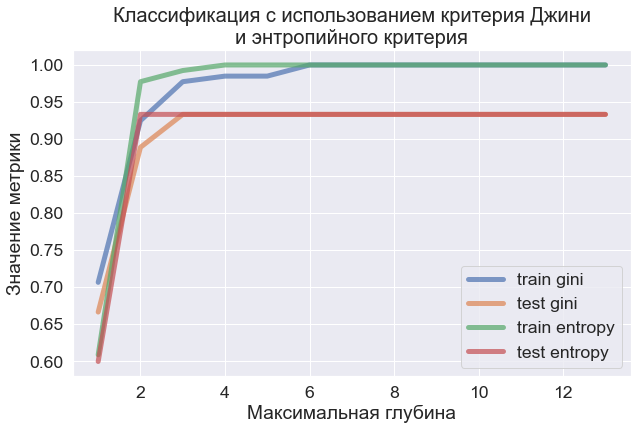

In [13]:
plot_graphs(DecisionTreeClassifier, 
            [(gini_criterion, 'gini'), (entropy_criterion, 'entropy')],
            accuracy_score,
            'Классификация с использованием критерия Джини\n' \
            + 'и энтропийного критерия')

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**

На графике видно, что с некоторого значения максимальной глубины точность классификации на тестовой выборке перестаёт расти. Это указывает на то, что, возможно, при больших значениях макс. глубины, чем это, происходит переобучение дерева.

Решающее дерево, использующее энтропийный критерий при разбиении, в среднем при разной глубине дало более высокий результат как на тестовой, так и на обучающей выборке.

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите r2_score. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [14]:
from sklearn.datasets import load_boston

boston_X, boston_y = load_boston(return_X_y=True)

In [15]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['mean_square', 'mean_abs']

Разобьём выборку на обучение и тест.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, 
                                                    random_state=777)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [17]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    dt_regressor = GridSearchCV(
        estimator=DecisionTreeRegressor(criterion),
        param_grid={
            'max_depth': np.arange(2, 11)
        },
        scoring='r2',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов
    )
    dt_regressor.fit(X_train, y_train)
    predictions = dt_regressor.predict(X_test)
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = dt.best_params_['max_depth']
    optimal_min_samples_split = dt.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    r2_value = r2_score(y_true=y_test, y_pred=predictions)
    print(f'r2_score на тесте: {r2_value:.3f}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Оптимальный max_depth: 4
Оптимальный min_samples_split: 3
r2_score на тесте: 0.675
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Оптимальный max_depth: 4
Оптимальный min_samples_split: 3
r2_score на тесте: 0.640


**Вывод.** 

В данном случае оптимальные параметры для обоих критериев разбиения совпадают. Однако, видно, что критерий, основанный на mse, даёт гораздо более высокий результат.

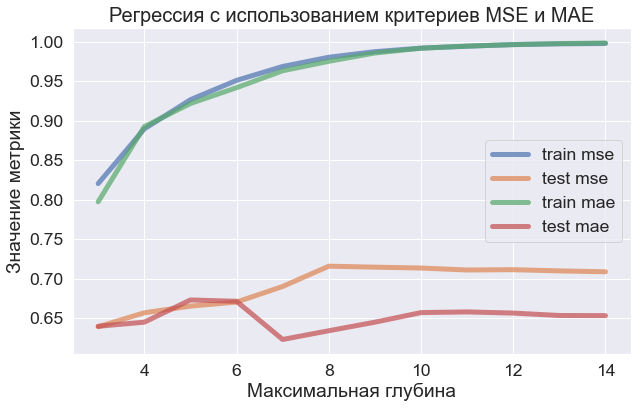

In [18]:
plot_graphs(DecisionTreeRegressor, 
            [(mean_square_criterion, 'mse'), (mean_abs_criterion, 'mae')], 
            r2_score,
            'Регрессия с использованием критериев MSE и MAE',
            max_depth_list=range(3, 15))

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

Качество результатов, выдаваемых решающим деревом, построенным с использованием mae критерия, оказалось ниже, чем даёт дерево, использующее mse критерий. На графике видно, что при `max_depth` $> 8$ решающее дерево для квадратичной функции потерь начинает переобучаться, так как `score` на обучающей выборке растёт, а на тестовой — падает.

Можно ускорить пострение решающего дерева, снизив асимптотику разбиения по признаку с $O(un)$ до $O(u+n \cdot \text{log} n)$, где $u$ &mdash; количество значений признака, а $n$ &mdash; количество различных значений.

Рассмотрим пример для MSE. Преобразуем функционал MSE:
$$MSE(y_1, ..., y_n) = \frac{1}{n}\sum\limits_{1}^n (y_i - \overline{Y})^2 = \overline{Y^2} - \overline{Y}^2.$$

Можно предподсчитать на префиксах и на суффиксах суммы квадратов и квадраты сумм $y_i$ и тогда значение каждого функционала будет вычислять не за линейное, а за константное время. Но перед использованием данного алгоритма, нужно отсортировать элементы, попавшие в вершину, по разделяемому признаку.

## Задача 3.5.5.

В этой задаче вам предстоит освоиться с обработкой пропусков в решающих деревьях, реализованной
ранее.

А теперь рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [19]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 
    'education2', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 2000 строк данных.

In [20]:
adult_df = pd.read_csv('adult.data', header=None)[:2000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

,age,workclass,fnlwgt,education1,education2,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [21]:
adult_df.shape

(2000, 14)

Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [22]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

,age,fnlwgt,education2,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,...,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [23]:
for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = np.arange(adult_df.shape[0])[
            adult_df[f'{feature}_ ?'] == 1
        ]
        
        for dummy_feature in adult_df.columns:
            if dummy_feature.startswith(f'{feature}_ ') \
                and dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = np.nan
                
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [24]:
np.sum(adult_df.isnull(), axis=0)

age                                 0
fnlwgt                              0
education2                          0
capital-gain                        0
capital-loss                        0
                                   ..
native-country_ Taiwan             39
native-country_ Thailand           39
native-country_ Trinadad&Tobago    39
native-country_ United-States      39
native-country_ Yugoslavia         39
Length: 99, dtype: int64

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    adult_df.values, target.values, random_state=777
)

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения для классификации.

In [26]:
criterion_names = ['gini', 'entropy']

In [27]:
for criterion, criterion_name in zip(classification_criteria, 
                                     criterion_names):
    dt_classifier = GridSearchCV(
        estimator=DecisionTreeClassifier(criterion),
        param_grid={
            'max_depth': np.arange(2, 10),
            'min_samples_split': np.arange(3, 14)
        },
        scoring='accuracy',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов
    )
    dt_classifier.fit(X_train, y_train)
    predictions = dt_classifier.predict(X_test)
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = dt.best_params_['max_depth']
    optimal_min_samples_split = dt.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    accuracy_value = accuracy_score(y_true=y_test, y_pred=predictions)
    print(f'Accuracy на тесте: {accuracy_value:.3f}')

Fitting 5 folds for each of 88 candidates, totalling 440 fits
Оптимальный max_depth: 4
Оптимальный min_samples_split: 3
Accuracy на тесте: 0.832
Fitting 5 folds for each of 88 candidates, totalling 440 fits
Оптимальный max_depth: 4
Оптимальный min_samples_split: 3
Accuracy на тесте: 0.832


Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

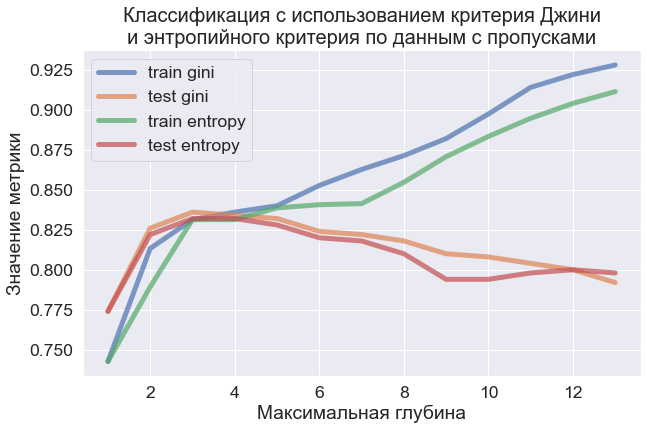

In [28]:
plot_graphs(
    DecisionTreeClassifier, 
    [(gini_criterion, 'gini'), (entropy_criterion, 'entropy')],
    accuracy_score, 
    'Классификация с использованием критерия Джини\n'
    'и энтропийного критерия по данным с пропусками'
)

**Вывод.**

По графикам видно, что дерево начинается переобучаться для `max_depth` $\geqslant 4$. Также можно заметить, что использование критерия Джини даёт лучшие результаты как на обучающей, так и на тестовой выборках.